# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
train_data = CIFAR10('./CIFAR10',train=True,transform=transforms.ToTensor(),download=True)
test_data = CIFAR10('./CIFAR10',train=False,transform=transforms.ToTensor(),download=True)

X_train = train_data.data.astype('float')
y_train = np.array(train_data.targets)

X_test = test_data.data.astype('float')
y_test = np.array(test_data.targets)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Files already downloaded and verified
Files already downloaded and verified
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


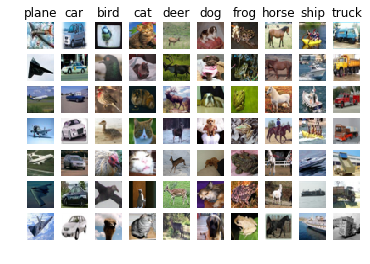

In [9]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y,cls in enumerate(classes):
  idxs = np.flatnonzero(y_train==y)
  idxs = np.random.choice(idxs,samples_per_class,replace=False)

  for i,idx in enumerate(idxs):
    plt_idx = num_classes*i+y+1
    plt.subplot(samples_per_class,num_classes,plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')

    if i==0:
      plt.title(cls)

plt.show()


In [10]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training,num_dev,replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [11]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_dev = X_dev.reshape(X_dev.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


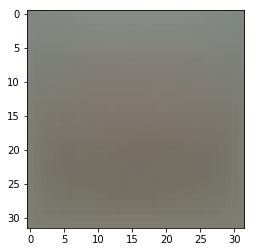

In [12]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.show()

In [13]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [14]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [16]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.368170
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 10개의 클래스의 예측확률이 균등하게 분포되어 있다면, 각 클래스의 예측확률은 1/10 = 0.1이 될것이다. softmax의 loss는 예측확률에 -log를 한것이므로, -log(0.1)이 된다.


In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.576604 analytic: 3.576604, relative error: 2.008363e-08
numerical: 1.274012 analytic: 1.274012, relative error: 5.781880e-08
numerical: 1.089271 analytic: 1.089271, relative error: 4.879721e-08
numerical: -1.944894 analytic: -1.944894, relative error: 2.035269e-08
numerical: 1.236007 analytic: 1.236007, relative error: 4.652512e-08
numerical: 1.293933 analytic: 1.293933, relative error: 1.215680e-08
numerical: -1.314338 analytic: -1.314338, relative error: 9.785249e-09
numerical: 1.436243 analytic: 1.436243, relative error: 1.514856e-08
numerical: 1.962702 analytic: 1.962701, relative error: 3.238511e-08
numerical: -0.061200 analytic: -0.061200, relative error: 4.505519e-08
numerical: 1.415066 analytic: 1.415066, relative error: 1.362539e-08
numerical: 1.167333 analytic: 1.167333, relative error: 2.226190e-08
numerical: -2.308346 analytic: -2.308346, relative error: 2.971176e-08
numerical: 2.651297 analytic: 2.651297, relative error: 2.273611e-08
numerical: 0.138682 analyt

In [18]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.368170e+00 computed in 0.086507s
vectorized loss: 2.368170e+00 computed in 0.011294s
Loss difference: 0.000000
Gradient difference: 0.000000


In [23]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for learning_rate in learning_rates:
  for reg in regularization_strengths:
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate = learning_rate, reg = reg, 
                  num_iters=1500,batch_size=200,verbose=True )
    y_pred = softmax.predict(X_train)
    train_accr = np.mean((y_pred == y_train))
    
    y_pred = softmax.predict(X_val)
    val_accr = np.mean((y_pred==y_val))

    results[(learning_rate,reg)] = (train_accr,val_accr)

    if best_val < val_accr:
      best_val = val_accr
      best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 773.309116
iteration 100 / 1500: loss 283.782487
iteration 200 / 1500: loss 105.130762
iteration 300 / 1500: loss 39.785189
iteration 400 / 1500: loss 15.903363
iteration 500 / 1500: loss 7.159533
iteration 600 / 1500: loss 3.924239
iteration 700 / 1500: loss 2.723022
iteration 800 / 1500: loss 2.381410
iteration 900 / 1500: loss 2.202377
iteration 1000 / 1500: loss 2.115051
iteration 1100 / 1500: loss 2.104991
iteration 1200 / 1500: loss 2.142041
iteration 1300 / 1500: loss 2.136931
iteration 1400 / 1500: loss 2.033796
iteration 0 / 1500: loss 1549.775180
iteration 100 / 1500: loss 208.726969
iteration 200 / 1500: loss 29.715585
iteration 300 / 1500: loss 5.828187
iteration 400 / 1500: loss 2.641350
iteration 500 / 1500: loss 2.200332
iteration 600 / 1500: loss 2.135941
iteration 700 / 1500: loss 2.171844
iteration 800 / 1500: loss 2.119460
iteration 900 / 1500: loss 2.118324
iteration 1000 / 1500: loss 2.101625
iteration 1100 / 1500: loss 2.120973
iteration 1

In [24]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.330000


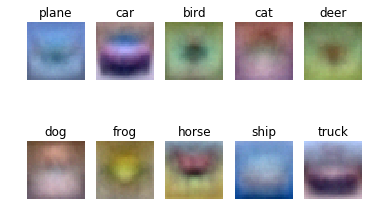

In [25]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])